# Sentiment Classification the old-fashioned way: 
## `Naive Bayes`, `Logistic Regression`, and `Ngrams`

In [1]:
 !curl -s https://course.fast.ai/setup/colab | bash #installing packages required to run on colab's gpus

Updating fastai...
Done.


The purpose of this notebook is to show how sentiment classification is done via the classic techniques of `Naive Bayes`, `Logistic regression`, and `Ngrams`.  We will be using `sklearn` and the `fastai` library.

In a future lesson, we will revisit sentiment classification using `deep learning`, so that you can compare the two approaches.

The content here was extended from [Lesson 10 of the fast.ai Machine Learning course](https://course.fast.ai/lessonsml1/lesson10.html). Linear model is pretty close to the state of the art here.  Jeremy surpassed state of the art using a RNN in fall 2017.

## 0.The fastai library

We will begin using [the fastai library](https://docs.fast.ai) (version 1.0) in this notebook.  We will use it more once we move on to neural networks.

The fastai library is built on top of PyTorch and encodes many state-of-the-art best practices. It is used in production at a number of companies.  You can read more about it here:

- [Fast.ai's software could radically democratize AI](https://www.zdnet.com/article/fast-ais-new-software-could-radically-democratize-ai/) (ZDNet)

- [fastai v1 for PyTorch: Fast and accurate neural nets using modern best practices](https://www.fast.ai/2018/10/02/fastai-ai/) (fast.ai)

- [fastai docs](https://docs.fast.ai/)

### Installation

With conda:

`conda install -c pytorch -c fastai fastai=1.0`

Or with pip:

`pip install fastai==1.0`

More [installation information here](https://github.com/fastai/fastai/blob/master/README.md).

Beginning in lesson 4, we will be using GPUs, so if you want, you could switch to a [cloud option](https://course.fast.ai/#using-a-gpu) now to setup fastai.

## 1. The IMDB dataset

<img src="https://github.com/will-thompson-k/course-nlp/blob/master/IMDb.png?raw=1" alt="floating point" style="width: 90%"/>

The [large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) contains a collection of 50,000 reviews from IMDB, We will use the version hosted as part [fast.ai datasets](https://course.fast.ai/datasets.html) on AWS Open Datasets. 

The dataset contains an even number of positive and negative reviews. The authors considered only highly polarized reviews. A negative review has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10. Neutral reviews are not included in the dataset. The dataset is divided into training and test sets. The training set is the same 25,000 labeled reviews.

The **sentiment classification task** consists of predicting the polarity (positive or negative) of a given text.

### Imports

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.text import *
from fastai.utils.mem import GPUMemTrace #call with mtrace

In [4]:
import sklearn.feature_extraction.text as sklearn_text
import pickle 

### Preview the sample IMDb data set

fast.ai has a number of [datasets hosted via AWS Open Datasets](https://course.fast.ai/datasets.html) for easy download. We can see them by checking the docs for URLs (remember `??` is a helpful command):

In [5]:
?? URLs

It is always good to start working on a sample of your data before you use the full dataset-- this allows for quicker computations as you debug and get your code working. For IMDB, there is a sample dataset already available:

In [6]:
path = untar_data(URLs.IMDB_SAMPLE)
path

PosixPath('/root/.fastai/data/imdb_sample')

#### Read the data set into a pandas dataframe, which we can inspect to get a sense of what our data looks like. We see that the three columns contain review label, review text, and the `is_valid` flag, respectively. `is_valid` is a boolean flag indicating whether the row is from the validation set or not.

In [7]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


### Extract the movie reviews from the sample IMDb data set.
#### We will be using [TextList](https://docs.fast.ai/text.data.html#TextList) from the fastai library:

In [8]:
%%time
# throws `BrokenProcessPool' Error sometimes. Keep trying `till it works!

count = 0
error = True
while error:
    try: 
        # Preprocessing steps
        movie_reviews = (TextList.from_csv(path, 'texts.csv', cols='text')
                         .split_from_df(col=2)
                         .label_from_df(cols=0))
        error = False
        print(f'failure count is {count}\n')    
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')


failure count is 0

CPU times: user 193 ms, sys: 50.7 ms, total: 244 ms
Wall time: 2.86 s


### Exploring IMDb review data

A good first step for any data problem is to explore the data and get a sense of what it looks like.  In this case we are looking at movie reviews, which have been labeled as "positive" or "negative". The reviews have already been `tokenized`, i.e. split into `tokens`, basic units such as words, prefixes, punctuation, capitalization, and other features of the text.

In [ ]:
movie_reviews

LabelLists;

Train: LabelList (800 items)
x: TextList
xxbos xxmaj un - xxunk - believable ! xxmaj meg xxmaj ryan does n't even look her usual xxunk lovable self in this , which normally makes me forgive her shallow xxunk acting xxunk . xxmaj hard to believe she was the producer on this dog . xxmaj plus xxmaj kevin xxmaj kline : what kind of suicide trip has his career been on ? xxmaj xxunk ... xxmaj xxunk ! ! ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a replay of xxmaj jonestown - hollywood style . xxmaj xxunk !,xxbos xxmaj this is a extremely well - made film . xxmaj the acting , script and camera - work are all first - rate . xxmaj the music is good , too , though it is mostly early in the film , when things are still relatively xxunk . xxmaj there are no really xxunk in the cast , though several faces will be familiar . xxmaj the entire cast does an excellent job with the script . 
 
  xxmaj but it is hard to watch , because there is n

### Let's examine the`movie_reviews` object:

In [ ]:
dir(movie_reviews)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'add_test',
 'add_test_folder',
 'databunch',
 'filter_by_func',
 'get_processors',
 'label_const',
 'label_empty',
 'label_from_df',
 'label_from_folder',
 'label_from_func',
 'label_from_list',
 'label_from_lists',
 'label_from_re',
 'lists',
 'load_empty',
 'load_state',
 'path',
 'process',
 'test',
 'train',
 'transform',
 'transform_y',
 'valid']

### `movie_reviews` splits the data into training and validation sets, `.train` and `.valid` 

In [9]:
print(f'There are {len(movie_reviews.train.x)} and {len(movie_reviews.valid.x)} reviews in the training and validations sets, respectively.')

There are 800 and 200 reviews in the training and validations sets, respectively.


### Reviews are composed of lists of tokens. In NLP, a **token** is the basic unit of processing (what the tokens are depends on the application and your choices). Here, the tokens mostly correspond to words or punctuation, as well as several special tokens, corresponding to unknown words, capitalization, etc.

### Special tokens:
All those tokens starting with "xx" are fastai special tokens.  You can see the list of all of them and their meanings ([in the fastai docs](https://docs.fast.ai/text.transform.html)): 

![image.png](attachment:image.png)

### Let's examine the structure of the `training set`

#### movie_reviews.train is a `LabelList` object. 
#### movie_reviews.train.x  is a `TextList` object that holds the reviews
#### movie_reviews.train.y is a `CategoryList` object that holds the labels 

In [10]:
print(f'\fThere are {len(movie_reviews.train.x)} movie reviews in the training set\n')
print(movie_reviews.train)

There are 800 movie reviews in the training set

LabelList (800 items)
x: TextList
xxbos xxmaj un - xxunk - believable ! xxmaj meg xxmaj ryan does n't even look her usual xxunk lovable self in this , which normally makes me forgive her shallow xxunk acting xxunk . xxmaj hard to believe she was the producer on this dog . xxmaj plus xxmaj kevin xxmaj kline : what kind of suicide trip has his career been on ? xxmaj xxunk ... xxmaj xxunk ! ! ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a replay of xxmaj jonestown - hollywood style . xxmaj xxunk !,xxbos xxmaj this is a extremely well - made film . xxmaj the acting , script and camera - work are all first - rate . xxmaj the music is good , too , though it is mostly early in the film , when things are still relatively xxunk . xxmaj there are no really xxunk in the cast , though several faces will be familiar . xxmaj the entire cast does an excellent job with the script . 
 
  xxmaj but it is hard

#### The text of the movie review is stored as a character `string`, which contains the tokens separated by spaces. Here is the text of the first review:

In [11]:
print(movie_reviews.train.x[0].text)
print(f'\nThere are {len(movie_reviews.train.x[0].text)} characters in the review')

xxbos xxmaj un - xxunk - believable ! xxmaj meg xxmaj ryan does n't even look her usual xxunk lovable self in this , which normally makes me forgive her shallow xxunk acting xxunk . xxmaj hard to believe she was the producer on this dog . xxmaj plus xxmaj kevin xxmaj kline : what kind of suicide trip has his career been on ? xxmaj xxunk ... xxmaj xxunk ! ! ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a replay of xxmaj jonestown - hollywood style . xxmaj xxunk !

There are 511 characters in the review


#### The text string can be split to get the list of tokens.

In [12]:
print(movie_reviews.train.x[0].text.split())
print(f'\nThe review has {len(movie_reviews.train.x[0].text.split())} tokens')

['xxbos', 'xxmaj', 'un', '-', 'xxunk', '-', 'believable', '!', 'xxmaj', 'meg', 'xxmaj', 'ryan', 'does', "n't", 'even', 'look', 'her', 'usual', 'xxunk', 'lovable', 'self', 'in', 'this', ',', 'which', 'normally', 'makes', 'me', 'forgive', 'her', 'shallow', 'xxunk', 'acting', 'xxunk', '.', 'xxmaj', 'hard', 'to', 'believe', 'she', 'was', 'the', 'producer', 'on', 'this', 'dog', '.', 'xxmaj', 'plus', 'xxmaj', 'kevin', 'xxmaj', 'kline', ':', 'what', 'kind', 'of', 'suicide', 'trip', 'has', 'his', 'career', 'been', 'on', '?', 'xxmaj', 'xxunk', '...', 'xxmaj', 'xxunk', '!', '!', '!', 'xxmaj', 'finally', 'this', 'was', 'directed', 'by', 'the', 'guy', 'who', 'did', 'xxmaj', 'big', 'xxmaj', 'xxunk', '?', 'xxmaj', 'must', 'be', 'a', 'replay', 'of', 'xxmaj', 'jonestown', '-', 'hollywood', 'style', '.', 'xxmaj', 'xxunk', '!']

The review has 103 tokens


#### The review tokens are `numericalized`, ie. mapped to integers.  So a movie review is also stored as an array of integers:

In [13]:
print(movie_reviews.train.x[0].data)
print(f'\nThe array contains {len(movie_reviews.train.x[0].data)} numericalized tokens')

[   2    5 4619   25 ...   10    5    0   52]

The array contains 103 numericalized tokens


## 2. The IMDb Vocabulary

### The `movie_revews` object also contains a `.vocab` property, even though it is not shown with`dir()`. (This may be an error in the `fastai` library.) 

In [15]:
movie_reviews.vocab

### The `vocab` object is a kind of reversible dictionary that translates back and forth between tokens and their integer representations.  It has two methods of particular interest: `stoi` and `itos`, which stand for `string-to-index` and `index-to-string`

#### `movie_reviews.vocab.stoi` maps vocabulary tokens to their `indexes` in vocab

In [ ]:
movie_reviews.vocab.stoi

defaultdict(int,
            {'xxunk': 0,
             'xxpad': 1,
             'xxbos': 2,
             'xxeos': 3,
             'xxfld': 4,
             'xxmaj': 5,
             'xxup': 6,
             'xxrep': 7,
             'xxwrep': 8,
             'the': 9,
             '.': 10,
             ',': 11,
             'and': 12,
             'a': 13,
             'of': 14,
             'to': 15,
             'is': 16,
             'it': 17,
             'in': 18,
             'i': 19,
             'that': 20,
             'this': 21,
             '"': 22,
             "'s": 23,
             '\n \n ': 24,
             '-': 25,
             'was': 26,
             'as': 27,
             'for': 28,
             'movie': 29,
             'with': 30,
             'but': 31,
             'film': 32,
             'you': 33,
             ')': 34,
             'on': 35,
             '(': 36,
             "n't": 37,
             'are': 38,
             'he': 39,
             'his': 40,
       

#### `movie_reviews.vocab.itos` maps the `indexes` of vocabulary tokens to `strings`

In [ ]:
movie_reviews.vocab.itos

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 '.',
 ',',
 'and',
 'a',
 'of',
 'to',
 'is',
 'it',
 'in',
 'i',
 'that',
 'this',
 '"',
 "'s",
 '\n \n ',
 '-',
 'was',
 'as',
 'for',
 'movie',
 'with',
 'but',
 'film',
 'you',
 ')',
 'on',
 '(',
 "n't",
 'are',
 'he',
 'his',
 'not',
 'have',
 'be',
 'one',
 'they',
 'all',
 'at',
 'by',
 'an',
 'from',
 'like',
 '!',
 'so',
 'who',
 'there',
 'about',
 'just',
 'out',
 'if',
 'or',
 'do',
 'what',
 'her',
 'has',
 "'",
 'some',
 'more',
 'good',
 'when',
 'up',
 'very',
 '?',
 'she',
 'would',
 'no',
 'really',
 'were',
 'their',
 'my',
 'had',
 'time',
 'can',
 'only',
 'which',
 'even',
 'see',
 'story',
 'me',
 'into',
 'did',
 ':',
 'well',
 'we',
 'will',
 'does',
 'than',
 'also',
 'get',
 '...',
 'people',
 'other',
 'bad',
 'been',
 'could',
 'first',
 'much',
 'how',
 'most',
 'any',
 'because',
 'two',
 'then',
 'great',
 'him',
 'its',
 'too',
 'made',
 'them',
 'after',


#### Notice that ints-to-string and string-to-ints have different lengths.  Think for a moment about why this is.
See Hint below

In [ ]:
print('itos ', 'length ',len(movie_reviews.vocab.itos),type(movie_reviews.vocab.itos) )
print('stoi ', 'length ',len(movie_reviews.vocab.stoi),type(movie_reviews.vocab.stoi) )

itos  length  6016 <class 'list'>
stoi  length  19160 <class 'collections.defaultdict'>


#### Hint: `stoi` is an instance of the class `defaultdict`
<img src="https://github.com/will-thompson-k/course-nlp/blob/master/default_dict.png?raw=1" alt="floating point" style="width: 90%"/>

#### In a `defaultdict`, rare words that appear fewer than three times in the corpus, and words that are not in the dictionary, are mapped to a `default value`, in this case, zero

In [ ]:
rare_words = ['acrid','a_random_made_up_nonexistant_word','acrimonious','allosteric','anodyne','antikythera']
for word in rare_words:
    print(movie_reviews.vocab.stoi[word])

0
0
0
0
0
0


#### What's the `token` corresponding to the `default` value?

In [ ]:
print(movie_reviews.vocab.itos[0])

xxunk


#### Note that `stoi` (string-to-int) is larger than `itos` (int-to-string).

In [ ]:
print(f'len(stoi) = {len(movie_reviews.vocab.stoi)}')
print(f'len(itos) = {len(movie_reviews.vocab.itos)}')
print(f'len(stoi) - len(itos) = {len(movie_reviews.vocab.stoi) - len(movie_reviews.vocab.itos)}')

len(stoi) = 19165
len(itos) = 6016
len(stoi) - len(itos) = 13149


#### This is because many words map to `unknown`.  We can confirm here:

In [16]:
unk = []
for word, num in movie_reviews.vocab.stoi.items():
    if num==0:
        unk.append(word)

In [17]:
len(unk)

13152

#### Question: why isn't len(unk) = len(stoi) - len(itos)?
Hint: remember the list of rare words we used to query `stoi` a few cells back?

#### Here are the first 25 words that are mapped to `unknown`

In [18]:
unk[:25]

['xxunk',
 'bleeping',
 'pert',
 'ticky',
 'schtick',
 'whoosh',
 'banzai',
 'chill',
 'wooofff',
 'cheery',
 'superstars',
 'fashionable',
 'cruelly',
 'separating',
 'mistreat',
 'tensions',
 'religions',
 'baseness',
 'nobility',
 'puro',
 'disowned',
 'option',
 'faults',
 'dignified',
 'realisation']

## 3. Map the movie reviews into a vector space

### There are 6016 unique tokens in the IMDb review vocabulary. Their numericalized values range from 0 to 6015

In [19]:
print(f'There are {len(movie_reviews.vocab.itos)} unique tokens in the IMDb review sample vocabulary')
print(f'The numericalized token values run from {min(movie_reviews.vocab.stoi.values())} to {max(movie_reviews.vocab.stoi.values())} ')

There are 6008 unique tokens in the IMDb review sample vocabulary
The numericalized token values run from 0 to 6007 


### Each review can be mapped to a 6016-dimensional `embedding vector` whose indices correspond to the numericalized tokens, and whose values are the number of times the corresponding token appeared in the review. To do this efficiently we need to learn a bit about `Counters`.

### 3A. Counters

A **Counter** is a useful Python object.  A **Counter** applied to a list returns an ordered dictionary whose keys are the unique elements in the list, and whose values are the counts of the unique elements. Counters are from the collections module (along with OrderedDict, defaultdict, deque, and namedtuple).
Here is how Counters work:

#### Let's make a TokenCounter for movie reviews

In [20]:
TokenCounter = lambda review_index : Counter((movie_reviews.train.x)[review_index].data)
TokenCounter(0).items()

dict_items([(2, 1), (5, 15), (4619, 1), (25, 3), (0, 8), (867, 1), (52, 5), (3776, 1), (1800, 1), (95, 1), (37, 1), (85, 1), (192, 1), (64, 2), (935, 1), (2738, 1), (517, 1), (18, 1), (21, 3), (11, 1), (84, 1), (2417, 1), (193, 1), (88, 1), (3777, 1), (1801, 1), (127, 1), (10, 3), (269, 1), (15, 1), (273, 1), (73, 1), (26, 2), (9, 2), (1360, 1), (35, 2), (1213, 1), (1144, 1), (1145, 1), (2418, 1), (91, 1), (63, 1), (245, 1), (14, 2), (1361, 1), (1447, 1), (65, 1), (40, 1), (796, 1), (103, 1), (72, 2), (99, 1), (534, 1), (616, 1), (48, 1), (282, 1), (54, 1), (90, 1), (219, 1), (228, 1), (43, 1), (13, 1), (3778, 1), (3779, 1), (355, 1), (492, 1)])

#### The TokenCounter `keys` are the numericalized `tokens` that apper in the review

In [ ]:
TokenCounter(0).keys()

dict_keys([2, 5, 4622, 25, 0, 867, 52, 3776, 1800, 95, 37, 85, 191, 63, 936, 2740, 517, 18, 21, 11, 84, 2418, 192, 88, 3777, 1801, 127, 10, 269, 15, 273, 73, 26, 9, 1360, 35, 1213, 1144, 1145, 2419, 91, 62, 245, 14, 1361, 1447, 64, 40, 797, 103, 72, 99, 534, 616, 48, 282, 54, 90, 219, 228, 43, 13, 3778, 3779, 355, 492])

#### The TokenCounter `values` are the `token multiplicities`, i.e the number of times each `token` appears in the review

In [21]:
TokenCounter(0).values()

dict_values([1, 15, 1, 3, 8, 1, 5, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### 3B. Mapping movie reviews to `embedding vectors`

#### Make a `count_vectorizer` function that represents a movie review as a 6016-dimensional `embedding vector`
#### The `indices` of  the `embedding vector` correspond to the n6016 numericalized tokens in the vocabulary; the `values` specify how often the corresponding token appears in the review. 

In [22]:
n_terms = len(movie_reviews.vocab.itos)
n_docs = len(movie_reviews.train.x)
make_token_counter = lambda review_index: Counter(movie_reviews.train.x[review_index].data)
def count_vectorizer(review_index,n_terms = n_terms,make_token_counter = make_token_counter):
    # input: review index, n_terms, and tokenizer function
    # output: embedding vector for the review
    embedding_vector = np.zeros(n_terms)        
    keys = list(make_token_counter(review_index).keys())
    values = list(make_token_counter(review_index).values())
    embedding_vector[keys] = values
    return embedding_vector

# make the embedding vector for the first review
embedding_vector = count_vectorizer(0)

#### Here is the `embedding vector` for the first review in the training data set

In [23]:
print(f'The review is embedded in a {len(embedding_vector)} dimensional vector')
embedding_vector

The review is embedded in a 6008 dimensional vector


array([8., 0., 1., 0., ..., 0., 0., 0., 0.])

## 4. Create the document-term matrix for the IMDb

#### In non-deep learning methods of NLP, we are often interested only in `which words` were used in a review, and `how often each word got used`. This is known as the `bag of words` approach, and it suggests a really simple way to store a document (in this case, a movie review). 

#### For each review we can keep track of which words were used and how often each word was used with a `vector` whose `length` is the number of tokens in the vocabulary, which we will call `n`. The `indexes` of this `vector` correspond to the `tokens` in the `IMDb vocabulary`, and the`values` of the vector are the number of times the corresponding tokens appeared in the review. For example the values stored at indexes 0, 1, 2, 3, 4 of the vector record the number of times the 5 tokens ['xxunk','xxpad','xxbos','xxeos','xxfld'] appeared in the review, respectively.

#### Now, if our movie review database has `m` reviews, and each review is represented by a `vector` of length `n`, then vertically stacking the row vectors for all the reviews creates a matrix representation of the IMDb, which we call its `document-term matrix`. The `rows` correspond to `documents` (reviews), while the `columns` correspond to `terms` (or tokens in the vocabulary).

In the previous lesson, we used [sklearn's CountVectorizer](https://github.com/scikit-learn/scikit-learn/blob/55bf5d9/sklearn/feature_extraction/text.py#L940) to generate the `vectors` that represent individual reviews. Today we will create our own (similar) version.  This is for two reasons:
- to understand what sklearn is doing underneath the hood
- to create something that will work with a fastai TextList

### Form the embedding vectors for the movie_reviews in the training set and stack them vertically

In [25]:
# Define a function to build the full document-term matrix
print(f'there are {n_docs} reviews, and {n_terms} unique tokens in the vocabulary')
def make_full_doc_term_matrix(count_vectorizer,n_terms=n_terms,n_docs=n_docs):
    
    # loop through the movie reviews
    for doc_index in range(n_docs):
        
        # make the embedding vector for the current review
        embedding_vector = count_vectorizer(doc_index,n_terms)    
            
        # append the embedding vector to the document-term matrix
        if(doc_index == 0):
            A = embedding_vector
        else:
            A = np.vstack((A,embedding_vector))
            
    # return the document-term matrix
    return A

# Build the full document term matrix for the movie_reviews training set
A = make_full_doc_term_matrix(count_vectorizer)

there are 800 reviews, and 6008 unique tokens in the vocabulary


### Explore the `sparsity` of the document-term matrix

#### The `sparsity` of a matrix is defined as the fraction of of zero-valued elements

In [26]:
NNZ = np.count_nonzero(A)
sparsity = (A.size-NNZ)/A.size
print(f'Only {NNZ} of the {A.size} elements in the document-term matrix are nonzero')
print(f'The sparsity of the document-term matrix is {sparsity}')

Only 112409 of the 4806400 elements in the document-term matrix are nonzero
The sparsity of the document-term matrix is 0.9766126414780293


#### Using matplotlib's `spy` method, we can visualize the structure of the `document-term matrix`
`spy` plots the array, indicating each non-zero value with a dot.

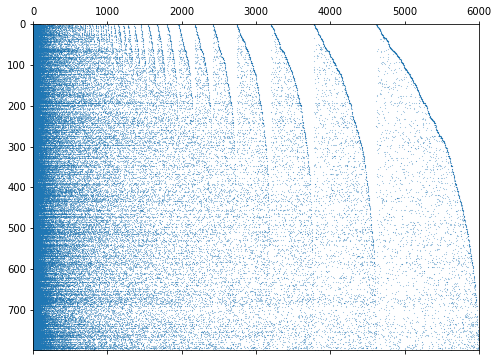

In [27]:
fig = plt.figure()
plt.spy(A, markersize=0.10, aspect = 'auto')
fig.set_size_inches(8,6)
fig.savefig('doc_term_matrix.png', dpi=800)

#### Several observations stand out:
1. Evidently, the document-term matrix is `sparse` ie. has a high proportion of zeros! 
2. The density of the matrix increases toward the `left` edge. This makes sense because the tokens are ordered by usage frequency, with frequency increasing toward the `left`.
3. There is a perplexing pattern of curved vertical `density ripples`. If anyone has an explanation, please let me know! 

#### Next we'll see how to  exploit matrix sparsity to save memory storage space, and compute time and resources.


## 5. Sparse Matrix Representation

#### Even though we've reduced over 19,000 unique words in our corpus of reviews down to a vocabulary of 6,000 words, that's still a lot! But reviews are generally short, a few hundred words. So most tokens don't appear in a typical review.  That means that most of the entries in the document-term matrix will be zeros, and therefore ordinary matrix operations will waste a lot of compute resources multiplying and adding zeros. 

####  We want to maximize the use of space and time by storing and performing matrix operations on our document-term matrix as a **sparse matrix**. `scipy` provides tools for efficient sparse matrix representatin and operations. 

#### Loosely speaking,  matrix with a high proportion of zeros is called `sparse` (the opposite of sparse is `dense`).  For sparse matrices, you can save a lot of memory by only storing the non-zero values.

#### More specifically, a class of matrices is called **sparse** if the number of non-zero elements is proportional to the number of rows (or columns) instead of being proportional to the product rows x columns. An example is the class of diagonal matrices.


<img src="https://github.com/will-thompson-k/course-nlp/blob/master/images/sparse.png?raw=1" alt="floating point" style="width: 30%"/>



### Visualizing sparse matrix structure
<img src="https://github.com/will-thompson-k/course-nlp/blob/master/sparse-matrix-structure-visualization.png?raw=1" alt="floating point" style="width: 90%"/>
ref. https://scipy-lectures.org/advanced/scipy_sparse/introduction.html

### Sparse matrix storage formats

<img src="https://github.com/will-thompson-k/course-nlp/blob/master/summary_of_sparse_matrix_storage_schemes.png?raw=1" alt="floating point" style="width: 90%"/>
ref. https://scipy-lectures.org/advanced/scipy_sparse/storage_schemes.html

There are the most common sparse storage formats:
- coordinate-wise (scipy calls COO)
- compressed sparse row (CSR)
- compressed sparse column (CSC)



### Definition of the Compressed Sparse Row (CSR) format

Let's start out with a presecription for the **CSR format** (ref. https://en.wikipedia.org/wiki/Sparse_matrix)

Given a full matrix **`A`** that has **`m`** rows, **`n`** columns, and **`N`** nonzero values, the CSR (Compressed Sparse Row) representation uses three arrays as follows:

1. **`Val[0:N]`** contains the **values** of the **`N` non-zero elements**.

2. **`Col[0:N]`** contains the **column indices** of the **`N` non-zero elements**. 
    
3. For each row **`i`** of **`A`**, **`RowPointer[i]`** contains the index in **Val** of the the first **nonzero value** in row **`i`**. If there are no nonzero values in the **ith** row, then **`RowPointer[i] = None`**. And, by convention, an extra value **`RowPointer[m] = N`** is tacked on at the end. 

Question: How many floats and ints does it take to store the matrix **`A`** in CSR format?

Let's walk through [a few examples](http://www.mathcs.emory.edu/~cheung/Courses/561/Syllabus/3-C/sparse.html) at the Emory University website



## 6. Store the document-term matrix in CSR format
i.e. given the `TextList` object containing the list of reviews, return the three arrays (values, column_indices, row_pointer)

### Scipy Implementation of sparse matrices

From the [Scipy Sparse Matrix Documentation](https://docs.scipy.org/doc/scipy-0.18.1/reference/sparse.html)

- To construct a matrix efficiently, use either dok_matrix or lil_matrix. The lil_matrix class supports basic slicing and fancy indexing with a similar syntax to NumPy arrays. As illustrated below, the COO format may also be used to efficiently construct matrices
- To perform manipulations such as multiplication or inversion, first convert the matrix to either CSC or CSR format.
- All conversions among the CSR, CSC, and COO formats are efficient, linear-time operations.

### To really understand the CSR format, we need to be able know how to do two things:
1. Translate a regular matrix A into CSR format
2. Reconstruct a regular matrix from its CSR sparse representation


### 6.1. Translate a regular matrix A into CSR format
This is done by implementing the definition of `CSR format`, given above.

In [41]:
# construct the document-term matrix in CSR format
# i.e. return (values, column_indices, row_pointer)
def get_doc_term_matrix(text_list, n_terms):
    
    # inputs:
    #    text_list, a TextList object
    #    n_terms, the number of tokens in our IMDb vocabulary
    
    # output: 
    #    the CSR format sparse representation of the document-term matrix in the form of a
    #    scipy.sparse.csr.csr_matrix object

    
    # initialize arrays
    values = []
    column_indices = []
    row_pointer = []
    row_pointer.append(0)

    # from the TextList object
    for _, doc in enumerate(text_list):
        feature_counter = Counter(doc.data)
        column_indices.extend(feature_counter.keys())
        values.extend(feature_counter.values())
        # Tack on N (number of nonzero elements in the matrix) to the end of the row_pointer array
        row_pointer.append(len(values))
        
    return scipy.sparse.csr_matrix((values, column_indices, row_pointer),
                                   shape=(len(row_pointer) - 1, n_terms),
                                   dtype=int)

#### Get the document-term matrix in CSR format for the training data

In [42]:
%%time
train_doc_term = get_doc_term_matrix(movie_reviews.train.x, len(movie_reviews.vocab.itos))

CPU times: user 129 ms, sys: 1.92 ms, total: 131 ms
Wall time: 131 ms


In [43]:
type(train_doc_term)

scipy.sparse.csr.csr_matrix

In [44]:
train_doc_term.shape

(800, 6008)

#### Get the document-term matrix in CSR format for the validation data

In [45]:
%%time
valid_doc_term = get_doc_term_matrix(movie_reviews.valid.x, len(movie_reviews.vocab.itos))

CPU times: user 35.9 ms, sys: 0 ns, total: 35.9 ms
Wall time: 35.9 ms


In [46]:
type(valid_doc_term)

scipy.sparse.csr.csr_matrix

In [47]:
valid_doc_term.shape

(200, 6008)

### 6.2 Reconstruct a regular matrix from its CSR sparse representation
#### Given a CSR format sparse matrix representation $(\text{values},\text{column_indices}, \text{row_pointer})$ of a $\text{m}\times \text{n}$ matrix $\text{A}$, <br> how can we recover $\text{A}$?

First create $\text{m}\times \text{n}$ matrix with all zeros.
We will recover $\text{A}$ by overwriting the entries in the zeros matrix row by row with the non-zero entries in $\text{A}$ as follows:

In [48]:
def CSR_to_full(values, column_indices, row_ptr, m,n):
    A = zeros(m,n)
    for row in range(n):
        if row_ptr is not null:
            A[row,column_indices[row_ptr[row]:row_ptr[row+1]]] = values[row_ptr[row]:row_ptr[row+1]]
    return A


## 7. IMDb data exploration exercises

#### The`.todense()` method converts a sparse matrix back to a regular (dense) matrix.

In [49]:
valid_doc_term

<200x6008 sparse matrix of type '<class 'numpy.int64'>'
	with 27848 stored elements in Compressed Sparse Row format>

In [50]:
valid_doc_term.todense()[:10,:10]

matrix([[32,  0,  1,  0, ...,  1,  0,  0, 10],
        [ 9,  0,  1,  0, ...,  1,  0,  0,  7],
        [ 6,  0,  1,  0, ...,  0,  0,  0, 12],
        [78,  0,  1,  0, ...,  0,  0,  0, 44],
        ...,
        [ 8,  0,  1,  0, ...,  0,  0,  0,  8],
        [43,  0,  1,  0, ...,  8,  1,  0, 25],
        [ 7,  0,  1,  0, ...,  1,  0,  0,  9],
        [19,  0,  1,  0, ...,  2,  0,  0,  5]])

#### Consider the second review in the validation set

In [51]:
review = movie_reviews.valid.x[1]
review

Text [  2  19 248  21 ...   9   0  10   0]

**Exercise 1:** How many times does the word "it" appear in this review? Confirm that the correct values is stored in the document-term matrix, for the row corresponding to this review and the column corresponding to the word "it".

#### Answer 1:

In [55]:
# try it! 
# Your code here.
len(review.text.split()),len(Counter(review.text.split())) #doesn't exactly match number below

(142, 80)

**Exercise 2**: Confirm that the review has 144 tokens, 81 of which are distinct

#### Answer 2:

In [56]:
valid_doc_term[1]

<1x6008 sparse matrix of type '<class 'numpy.int64'>'
	with 81 stored elements in Compressed Sparse Row format>

In [57]:
valid_doc_term[1].sum()

144

In [ ]:
len(set(review.data))

81

**Exercise 3:** How could you convert review.data back to text (without just using review.text)?

In [58]:
review.data

array([  2,  19, 248,  21, ...,   9,   0,  10,   0])

#### Answer 3:

In [59]:
word_list = [movie_reviews.vocab.itos[a] for a in review.data]
print(word_list)

['xxbos', 'i', 'saw', 'this', 'movie', 'once', 'as', 'a', 'kid', 'on', 'the', 'late', '-', 'late', 'show', 'and', 'fell', 'in', 'love', 'with', 'it', '.', '\n \n ', 'xxmaj', 'it', 'took', '30', '+', 'years', ',', 'but', 'i', 'recently', 'did', 'find', 'it', 'on', 'xxup', 'dvd', '-', 'it', 'was', "n't", 'cheap', ',', 'either', '-', 'in', 'a', 'xxunk', 'that', 'xxunk', 'in', 'war', 'movies', '.', 'xxmaj', 'we', 'watched', 'it', 'last', 'night', 'for', 'the', 'first', 'time', '.', 'xxmaj', 'the', 'audio', 'was', 'good', ',', 'however', 'it', 'was', 'grainy', 'and', 'had', 'the', 'trailers', 'between', 'xxunk', '.', 'xxmaj', 'even', 'so', ',', 'it', 'was', 'better', 'than', 'i', 'remembered', 'it', '.', 'i', 'was', 'also', 'impressed', 'at', 'how', 'true', 'it', 'was', 'to', 'the', 'play', '.', '\n \n ', 'xxmaj', 'the', 'xxunk', 'is', 'around', 'here', 'xxunk', '.', 'xxmaj', 'if', 'you', "'re", 'xxunk', 'in', 'finding', 'it', ',', 'fire', 'me', 'a', 'xxunk', 'and', 'i', "'ll", 'see', 'if',

In [60]:
reconstructed_text = ' '.join(word_list)
print(reconstructed_text)

xxbos i saw this movie once as a kid on the late - late show and fell in love with it . 
 
  xxmaj it took 30 + years , but i recently did find it on xxup dvd - it was n't cheap , either - in a xxunk that xxunk in war movies . xxmaj we watched it last night for the first time . xxmaj the audio was good , however it was grainy and had the trailers between xxunk . xxmaj even so , it was better than i remembered it . i was also impressed at how true it was to the play . 
 
  xxmaj the xxunk is around here xxunk . xxmaj if you 're xxunk in finding it , fire me a xxunk and i 'll see if i can get you the xxunk . xxunk


## *Video 4 material ends here.* 
## *Video 5 material begins below.*

## 8. What is a [Naive Bayes classifier](https://towardsdatascience.com/the-naive-bayes-classifier-e92ea9f47523)? 


#### The `bag of words model` considers a movie review as equivalent to a list of the counts of all the tokens that it contains. When you do this, you throw away the rich information that comes from the sequential arrangement of the tokens into sentences and paragraphs. 

#### Nevertheless, even if you are not allowed to read the review but are only given its representation as `token counts`, you can usually still get a pretty good sense of whether the review was good or bad. How do you do this?  By mentally gauging the overall `positive` or `negative` sentiment that the collection of words conveys, right?  

#### The `Naive Bayes Classifier` is an algorithm that encodes this simple reasoning process mathematically. It is based on two important pieces of information that we can learn from the training set:
* The `class priors`, i.e. the probabilities that a randomly chosen review will be `positive`, or `negative`
* The `token likelihoods` i.e. how likely is it that a given token would appear in a `positive` or `negative` review 

#### It turns out that this is all the information we need to build a model capable of predicting fairly accurately how any given review will be classified, given its text! 

#### We shall unfold the complete explanation of the magic of the Naive Bayes Classifier in the next section. 

#### Meanwhile, In this section, we focus on how to compute the necessary information from the training data, specifically the `prior probabilities` for reviews of each class, and the `class occurrence counts` and `class likelihood ratios` for each `token` in the `vocabulary`. 

### 8A. Class priors

#### From the training data we can determine the `class priors` $p$ and $q$, which are the overall probabilities that a randomly chosen review is in the `positive`, or `negative` class, resepectively. 

#### $p=\frac{N^{+}}{N}$ 
#### and
#### $q=\frac{N^{-}}{N}$ 

#### Here $N^{+}$ and $N^{-}$ are the numbers of `positive` and `negative` reviews, and $N$ is the total number of reviews in the training set, so that 

#### $N = N^{+} + N^{-}$, 

#### and 

#### $q = 1-p$

### 8B. Class `occurrence counts`

#### Let $C^{+}_{t}$ and $C^{-}_{t}$ be the `occurrence counts` of token $t$ in `positive` and `negative` reviews, respectively, and $N^{+}$ and $N^{-}$ be the total numbers of`positive` and `negative` reviews in the data set, respectively. 


### 8B.1 Data exploration with class `occurrence counts`

#### Movie reviews classes and their integer representations

In [ ]:
dir(movie_reviews)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'add_test',
 'add_test_folder',
 'databunch',
 'filter_by_func',
 'get_processors',
 'label_const',
 'label_empty',
 'label_from_df',
 'label_from_folder',
 'label_from_func',
 'label_from_list',
 'label_from_lists',
 'label_from_re',
 'lists',
 'load_empty',
 'load_state',
 'path',
 'process',
 'test',
 'train',
 'transform',
 'transform_y',
 'valid']

In [ ]:
movie_reviews.y.c

2

In [ ]:
movie_reviews.y.classes

['negative', 'positive']

In [ ]:
positive = movie_reviews.y.c2i['positive']
negative = movie_reviews.y.c2i['negative']
print(f'Integer representations:  positive: {positive}, negative: {negative}')

Integer representations:  positive: 1, negative: 0


#### Brief names for training set document term matrix and its labels, validation labels, and vocabulary

In [ ]:
x = train_doc_term
y = movie_reviews.train.y
valid_y = movie_reviews.valid.y
v = movie_reviews.vocab

In [ ]:
x.shape

(800, 260402)

#### The `count arrays` `C1` and `C0` list the total `occurrence counts` of the tokens in `positive` and `negative` reviews, respectively.

In [ ]:
C1 = np.squeeze(np.asarray(x[y.items==positive].sum(0)))
C0 = np.squeeze(np.asarray(x[y.items==negative].sum(0)))

For each vocabulary token, we are summing up how many positive reviews it is in, and how many negative reviews it is in. Here are the occurrence counts for the first 10 tokens in the vocabulary.

In [ ]:
print(C1[:10])
print(C0[:10])

[ 6468     0   383     0     0 10267   674    57     0  5260]
[ 7153     0   417     0     0 10741   908    53     1  6150]


### 8B.2 Exercise

#### We can use `C0` and `C1` to do some more data exploration!

**Exercise 4**: Compare how often the word "loved" appears in positive reviews vs. negative reviews.  Do the same for the word "hate"

#### Answer 4:

In [ ]:
# Exercise: How often does the word "love" appear in neg vs. pos reviews?
ind = v.stoi['love']
pos_counts = C1[ind] 
neg_counts = C0[ind] 
print(f'The word "love" appears {pos_counts} and {neg_counts} times in positive and negative documents, respectively')

The word "love" appears 133 and 75 times in positive and negative documents, respectively


In [ ]:
# Exercise: How often does the word "hate" appear in neg vs. pos reviews?
ind = v.stoi['hate']
pos_counts = C1[ind] 
neg_counts = C0[ind] 
print(f'The word "hate" appears {pos_counts} and {neg_counts} times in positive and negative documents, respectively')

The word "hate" appears 5 and 13 times in positive and negative documents, respectively


#### Let's look for an example of a positive review containing the word "hated"

In [ ]:
index = v.stoi['hated']
a = np.argwhere((x[:,index] > 0))[:,0]
print(a)
b = np.argwhere(y.items==positive)[:,0]
print(b)
c = list(set(a).intersection(set(b)))[0]
review = movie_reviews.train.x[c]
review.text

[ 15  49 304 351 393 612 695 773]
[  1   3  10  11 ... 787 789 790 797]


'xxbos xxmaj there are numerous films relating to xxup xxunk , but xxmaj mother xxmaj night is quite xxunk among them : xxmaj in this film , we are introduced to xxmaj howard xxmaj campbell ( xxmaj nolte ) , an xxmaj american living in xxmaj berlin and married to a xxmaj german , xxmaj xxunk xxmaj xxunk ( xxmaj lee ) , who decides to accept the role of a spy : xxmaj more specifically , a xxup cia agent xxmaj major xxmaj xxunk ( xxmaj goodman ) recruits xxmaj campbell who becomes a xxmaj nazi xxunk in order to enter the highest xxunk of the xxmaj hitler xxunk . xxmaj however , the deal is that the xxup us xxmaj government will never xxunk xxmaj campbell \'s role in the war for national security reasons , and so xxmaj campbell becomes a hated figure across the xxup us . xxmaj after the war , he tries to xxunk his identity , but the past comes back and xxunk him . xxmaj his only " friend " is xxmaj xxunk , but even he can not do much for the xxunk of events that fall upon poor xxmaj campb

#### Example of a negative review with the word "loved"

In [ ]:
index = v.stoi['loved']
a = np.argwhere((x[:,index] > 0))[:,0]
print(a)
b = np.argwhere(y.items==negative)[:,0]
print(b)
c = list(set(a).intersection(set(b)))[0]
review = movie_reviews.train.x[c]
review.text

[  1  15  29  69  75  79 174 185 200 205 262 296 303 333 350 351 398 407 440 489 496 528 538 600 602 605 627 642 657
 660 700 712 729 735 755 767 785]
[  0   2   4   5 ... 795 796 798 799]


'xxbos xxmaj oh if only i could give this rubbish less than one star ! xxmaj there were two mildly amusing parts in the whole film and that is it ! one was where a line or two from the song xxmaj do n\'t xxmaj worry , xxmaj be xxmaj happy was xxunk by the slugs and the other was where xxmaj roddy fell of the toilet roll and landed with his feet and legs apart so that everything else he landed on on the way down hit him in the xxunk . xxmaj that is it there was nothing more amusing than that , at least not for me anyway ! xxmaj xxunk is not right in saying \' xxmaj fans of the completely terrible " xxmaj shrek " might enjoy , but " xxmaj wallace & xxmaj xxunk " fans will probably turn away in xxunk . \' xxmaj as i loved xxmaj shrek 1 2 and 3 and i also love xxmaj wallace and xxmaj xxunk . xxmaj you see what it xxunk down to is that if an animation is done extremely well then it is definitely worth watching , this however was about as far from done well as you can possibly get ! xxmaj th

### 8C. Class likelihood ratios

#### Then, given the knowledge that a review is classified as `positive`, the `conditional likelihood` that a token $t$ will appear in the review is
### $ L(t|+) = \frac{C^{+}_{t}}{N^+}$, 
#### and simlarly, the `conditional likelihood` of a token appearing in a `negative` review is 
### $ L(t|-) = \frac{C^{-}_{t}}{N^-}$

### 8D. The `log-count ratio`

#### From the class likelihood ratios, we can define a **log-count ratio** $R_{t}$ for each token $t$ as
### $ R_{t} = \text{log} \frac{L(t|+)}  {L(t|-)}$
#### The `log-count ratio` ranks tokens by their relative affinities for positive and negative reviews
#### We observe that
* $R_{t} \gt 0$ means `positive` reviews are more likely to contain this token 
* $R_{t} \lt 0$ means `negative` reviews are more likely to contain this token 
* $R_{t} = 0$ indicates the token $t$ has equal likelihood to appear in  `positive` and `negative` reviews


## 9. Building a Naive Bayes Classifier for IMDb movie reviews

#### From the `occurrence count` arrays, we can compute the `class likelihoods` and `log-count ratios` of all the tokens in the vocabulary. 

### 9A. Compute the `class likelihoods`

#### We compute slightly modified `conditional likelihoods`, by adding 1 to the numerator and denominator to insure numerically stability.

In [ ]:
L1 = (C1+1) / ((y.items==positive).sum() + 1)
L0 = (C0+1) / ((y.items==negative).sum() + 1)

### 9B. Compute the `log-count ratios`

#### The log-count ratios are

In [ ]:
R = np.log(L1/L0)
print(R)

[-0.015811  0.084839  0.        0.084839 ...  0.084839  0.084839  0.084839  0.084839]


#### Data Exercise: find the vocabulary words most likely to be associated with positive and negative reviews

#### Get the indices of the tokens with the highest and lowest log-count ratios

In [ ]:
n_tokens = 10
highest_R = np.argpartition(R, -n_tokens)[-n_tokens:]
lowest_R = np.argpartition(R, n_tokens)[:n_tokens]

In [ ]:
print(f'Highest {n_tokens} log-count ratios: {R[list(highest_R)]}\n')
print(f'Lowest {n_tokens} log-count ratios: {R[list(lowest_R)]}')

Highest 10 log-count ratios: [2.569746 2.649788 2.649788 2.723896 2.723896 2.649788 2.792889 2.857428 2.975211 3.029278]

Lowest 10 log-count ratios: [-2.68775  -2.554218 -2.8596   -3.134037 -2.623211 -3.093215 -2.805533 -2.748374 -2.636457 -2.554218]


#### Most positive words:

In [ ]:
highest_R

array([1723, 1662, 1620,  796, 1529, 1666, 1386, 1358, 1212, 1143], dtype=int64)

In [ ]:
[v.itos[k] for k in highest_R]

['sport',
 'davies',
 'jabba',
 'jimmy',
 'felix',
 'gilliam',
 'noir',
 'astaire',
 'fanfan',
 'biko']

#### There are only two movie reviews that mention "biko"

In [ ]:
token = 'biko'
train_doc_term[:,v.stoi[token]]

<800x1 sparse matrix of type '<class 'numpy.int32'>'
	with 2 stored elements in Compressed Sparse Row format>

#### Which movie review has the most occurrences of 'biko'?

In [ ]:
index = np.argmax(train_doc_term[:,v.stoi[token]])
n_times = train_doc_term[index,v.stoi[token]]
print(f'review # {index} has {n_times} occurrences of "{token}"\n')
print(movie_reviews.train.x[index].text)

review # 515 has 14 occurrences of "biko"

xxbos " xxmaj the xxmaj true xxmaj story xxmaj of xxmaj the xxmaj friendship xxmaj that xxmaj shook xxmaj south xxmaj africa xxmaj and xxmaj xxunk xxmaj the xxmaj world . " 
 
  xxmaj richard xxmaj attenborough , who directed " a xxmaj bridge xxmaj too xxmaj far " and " xxmaj gandhi " , wanted to bring the story of xxmaj steve xxmaj biko to life , and the journey and trouble that xxunk xxmaj donald xxmaj woods went through in order to get his story told . xxmaj the films uses xxmaj wood 's two books for it 's information and basis - " xxmaj biko " and " xxmaj asking for xxmaj trouble " . 
 
  xxmaj the film takes place in the late 1970 's , in xxmaj south xxmaj africa . xxmaj south xxmaj africa is in the grip of the terrible apartheid , which keeps the blacks separated from the whites and xxunk the whites as the superior race . xxmaj the blacks are forced to live in xxunk on the xxunk of the cities and xxunk , and they come under frequent xxun

#### Most negative words:

In [ ]:
lowest_R

array([1345, 1545,  572,  904, 1438,  935, 1189, 1213,  301, 1544], dtype=int64)

In [ ]:
[v.itos[k] for k in lowest_R]

['crater',
 'soderbergh',
 'crap',
 'porn',
 'disappointment',
 'vargas',
 'naschy',
 'dog',
 'worst',
 'fuqua']

#### There's only one movie review that mentions "soderbergh"

In [ ]:
token = 'soderbergh'
train_doc_term[:,v.stoi[token]]

<800x1 sparse matrix of type '<class 'numpy.int32'>'
	with 1 stored elements in Compressed Sparse Row format>

In [ ]:
index = np.argmax(train_doc_term[:,v.stoi[token]])
n_times = train_doc_term[index,v.stoi[token]]
print(f'review # {index} has {n_times} occurrences of "{token}"\n')
print(movie_reviews.train.x[index].text)


review # 434 has 13 occurrences of "soderbergh"

xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of " xxmaj at xxmaj the xxmaj movies " in taking xxmaj steven xxmaj soderbergh to task . 
 
  xxmaj it 's usually satisfying to watch a film director change his style / subject , but xxmaj soderbergh 's most recent stinker , xxmaj the xxmaj girlfriend xxmaj xxunk ) , was also missing a story , so narrative ( and editing ? ) seem to suddenly be xxmaj soderbergh 's main challenge . xxmaj strange , after xxunk years in the business . xxmaj he was probably never much good at narrative , just xxunk it well inside " edgy " projects . 
 
  xxmaj none of this excuses him this present , almost diabolical failure . xxmaj as xxmaj david xxmaj xxunk xxunk , " two parts of xxmaj che do n't ( even ) make a whole " . 
 
  xxmaj epic xxunk in name only , xxmaj ch

In [ ]:
train_doc_term[:,v.stoi[token]]

<800x1 sparse matrix of type '<class 'numpy.int32'>'
	with 1 stored elements in Compressed Sparse Row format>

### 9C. Compute the prior probabilities for  each class

In [ ]:
p = (y.items==positive).mean()
q = (y.items==negative).mean()
print(f'The prior probabilities for positive and negative classes are {p} annd {q}')

The prior probabilities for positive and negative classes are 0.47875 annd 0.52125


#### The log probability ratio is

### $b = \text{log} \frac{p} {q}$ 

#### is a measure of the `bias`, or `imbalance` in the data set. 

* $b = 0$ indicates a perfectly balanced data set
* $b \gt 0$ indicates bias towards `positive` reviews 
* $b \lt 0$ indicates bias towards `negative` reviews 

In [ ]:
b = np.log((y.items==positive).mean() / (y.items==negative).mean())
print(f'The log probability ratio is L = {b}')

The log probability ratio is L = -0.08505123261815539


#### We see that the training set is slightly imbalanced toward `negative` reviews.

### 9D.  Putting it all together: the Naive Bayes Movie Review Classifier
In this section, we'll start with a discussion of Bayes' Theorem, then we'll use it to derive the Naive Bayes Classifier. Next we'll apply the Naive Bayes classifier to our movie reviews problem. Finally we'll review the prescription for building a Naive Bayes Classifier. 

### 9D.1 What is Bayes Theorem, and what does it have to say about IMDb movie reviews?

Consider two events, $A$ and $B$  
Then the probability of $A$ and $B$ occurring together can be written in two ways:
$p(A,B) = p(A|B)\cdot p(B)$
$p(A,B) = p(B|A)\cdot p(A)$

where $p(A|B)$ and $p(B|A)$ are conditional probabilities:
$p(A|B)$ is the probability of $A$ occurring given that $B$ has occurred,
$p(A)$ is the probability that $A$ occurs,
$p(B)$ is the probabilityt that $B$ occurs


$\textbf{Bayes Theorem}$ is just the statement that the right hand sides of the above two equations are equal:

$p(A|B) \cdot p(B) = p(B|A) \cdot p(A)$

Applying $\textbf{Bayes Theorem}$ to our IMDb movie review problem:

We identify $A$ and $B$ as <br> 
$A \equiv \text{class}$, i.e. positive or negative, and <br>
$B \equiv \text{tokens}$, i.e. the "bag" of tokens used in the review

Then $\textbf{Bayes Theorem}$ says

$p(\text{class}|\text{tokens})\cdot p(\text{tokens}) = p(\text{tokens}|\text{class}) \cdot p(\text{class})$

so that <br>
$p(\text{class}|\text{tokens}) = p(\text{tokens}|\text{class})\cdot \frac{p(\text{class})}{p(\text{tokens})}$

Since $p(\text{tokens})$ is a constant, we have the proportionality 

$p(\text{class}|\text{tokens}) \propto p(\text{tokens}|\text{class})\cdot p(\text{class})$

The left hand side of the above expression is called the $\textbf{posterior class probability}$, the probability that the review is positive (or negative), given the tokens it contains. This is exactly what we want to predict!

### 9D.2 The Naive Bayes Classifier

#### Given the list of tokens in a review, we seek to predict whether the review is rated as `positive` or `negative` 

#### We can make the prediction if we know the `posterior class probabilities`.

#### $p(\text{class}|\text{tokens})$,
#### where $\text{class}$ is either `positive` or `negative`, and $\text{tokens}$ is the list of tokens that appear in the review.
#### [Bayes' Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) tells us that the posterior probabilities, the likelihoods and the priors are related this way:

#### $p(\text{class}|\text{tokens}) \propto p(\text{tokens}|\text{class})\cdot p(\text{class})$

#### Now the tokens are not independent of one another.  For example, 'go' often appears with 'to', so if 'go' appears in a review it is more likely that the review also contains 'to'. Nevertheless, assuming the tokens are independent allows us to simplify things, so we recklessly do it, hoping it's not too wrong!
#### $p(\text{tokens}|\text{class}) = \prod_{i=1}^{n} p(t_{i}|\text{class})$

#### where $t_{i}$ is the $i\text{th}$ token in the vocabulary and $n$ is the number of tokens in the vocabulary. 

#### So Bayes' theorem is

#### $p(\text{class}|\text{tokens}) \propto p(\text{class}) \prod_{i=1}^{n} p(t_{i}|\text{class}) $

#### Taking the ratio of the $\textbf{posterior class probabilities}$ for the `positive` and `negative` classes, we have

#### $\frac{p(+|\text{tokens})}{p( - |\text{tokens})} =  \frac{p(+)}{p( - )}  \cdot  \prod_{i=1}^{n} \frac {p(t_{i}|+)}  {p(t_{i}| - )} = \frac{p}{q}  \cdot  \prod_{i=1}^{n} \frac {L(t_{i}|+)}  {L(t_{i}| - )}$
#### since likelihoods are proportional to probabilities.
#### Taking the log of both sides converts this to a `linear` problem:
#### $\text{log} \frac{p(+|\text{tokens})}{p( - |\text{tokens})} = \text{log}\frac{p}{q} + \sum_{i=1}^{n} \text{log} \frac {L(t_{i}|+)}  {L(t_{i}| - )} = b + \sum_{i=1}^{n}  R_{t_{i}}$

#### The first term on the right-hand side is the `bias`, and the second term is the dot product of the *binarized* embedding vector and the log-count ratios

#### If the left-hand side is greater than or equal to zero, we predict the review is `positive`, else we predict the review is `negative`. 

####  We can re-write the last equation in matrix form to generate a $m \times 1$ boolean column vector $\textbf{preds}$ of review predictions:

#### $\textbf{preds} = \textbf{W} \cdot \textbf{R} + \textbf{b}$
#### where 

* $\textbf{preds} \equiv \text{log} \frac{p(+|\text{tokens})}{p( - |\text{tokens})}$
* $\textbf{W}$ is the $m\times n$ `binarized document-term matrix`, whose rows are the binarized embedding vectors for the movie reviews
* $\textbf{R}$ is the $n\times 1$ vector of `log-count ratios`  for the tokens, and 
* $\textbf{b}$ is a $n\times 1$ vector whose entries are the bias $b$


#### The Naive Bayes model consists of the log-counts vector $\textbf{R}$ and the bias $\textbf{b}$

### 9E. Implement our Naive Bayes Movie Review classifier
#### and use it to predict labels for the training and validation sets of the IMDb_sample data.

In [ ]:
W = train_doc_term.sign()
preds_train = (W @ R + b) > 0
train_accuracy = (preds_train == y.items).mean()
print(f'The prediction accuracy for the training set is {train_accuracy}')

The prediction accuracy for the training set is 0.9


In [ ]:
W = valid_doc_term.sign()
preds_valid = (W @ R + b) > 0
valid_accuracy = (preds_valid == valid_y.items).mean()
print(f'The prediction accuracy for the validation set is {valid_accuracy}')

The prediction accuracy for the validation set is 0.68


### 9F. Summary: A recipe for the Naive Bayes  Classifier
#### Here is a summary of our procedure for predicting labels with the Naive Bayes Classifier, starting with the training set `x` and the training labels `y`


#### 1. Compute the token count vectors
> C0 = np.squeeze(np.asarray(x[y.items==negative].sum(0))) <br> 
> C1 = np.squeeze(np.asarray(x[y.items==positive].sum(0))) <br> 

#### 2. Compute the token class likelihood vectors
> L0 = (C0+1) / ((y.items==negative).sum() + 1) <br> 
> L1 = (C1+1) / ((y.items==positive).sum() + 1) <br> 

#### 3. Compute the log-count ratios vector
> R = np.log(L1/L0)

#### 4. Compute the bias term
> b = np.log((y.items==positive).mean() / (y.items==negative).mean())

#### 5. The Naive Bayes model consists of the log-counts vector $\textbf{R}$ and the bias $\textbf{b}$
#### 6. Predict the movie review labels from a linear transformation of the log-count ratios vector:
> preds = (W @ R + b) > 0, <br> 
> where the weights matrix W = valid_doc_term.sign() is the binarized `valid_doc_term matrix` whose rows are the binarized embedding vectors for the movie reviews for which you want to predict ratings.


## 10. Working with the full IMDb data set

Now that we have our approach working on a smaller sample of the data, we can try using it on the full dataset.

### 10A. Download the data

In [ ]:
path = untar_data(URLs.IMDB)
path.ls()

[WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/data_clas.pkl'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/data_lm.pkl'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/finetuned.pth'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/finetuned_enc.pth'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/imdb.vocab'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/ld.pkl'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/ll_clas.pkl'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/ll_lm.pkl'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/models'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/pretrained'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/README'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/test'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/tmp_clas'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/tmp_lm'),
 WindowsPath('C:/Users/cross-entropy/.fastai

In [ ]:
(path/'train').ls()

[WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/train/labeledBow.feat'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/train/neg'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/train/pos'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/train/unsupBow.feat')]

### 10B. Preprocess the data

#### Attempt to split and label the data fails most of the time, throwing a `BrokenProcessPool`  error; we apply a `brute force` approach, trying repeatedly until we succeed. Takes 10 minutes if it goes on the first try.

In [ ]:
%%time
# throws `BrokenProcessPool' Error sometimes. Keep trying `till it works!
count = 0
error = True
while error:
    try: 
        # Preprocessing steps
        reviews_full = (TextList.from_folder(path)
             #  Make a `TextList` object that is a list of `WindowsPath` objects, 
             #     each of which contains the full path to one of the data files.
             .split_by_folder(valid='test')
             # Generate a `LabelLists` object that splits files by training and validation folders
             # Note: .label_from_folder in next line causes the `BrokenProcessPool` error
             .label_from_folder(classes=['neg', 'pos']))
             # Create a `CategoryLists` object which contains the data and
             #   its labels that are derived from folder names
        error = False
        print(f'failure count is {count}\n')    
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')


failure count is 9

Wall time: 13min 4s


### 10C. Create document-term matrices for training and validation sets. 
#### This takes about ~4 sec per matrix

In [ ]:
%%time
valid_doc_term = get_doc_term_matrix(reviews_full.valid.x, len(reviews_full.vocab.itos))

Wall time: 3.72 s


In [ ]:
%%time
train_doc_term = get_doc_term_matrix(reviews_full.train.x, len(reviews_full.vocab.itos))

Wall time: 3.78 s


### 10D. Save the data
When storing data like this, always make sure it's included in your `.gitignore` file

In [ ]:
scipy.sparse.save_npz("train_doc_term.npz", train_doc_term)

In [ ]:
scipy.sparse.save_npz("valid_doc_term.npz", valid_doc_term)

In [ ]:
with open('reviews_full.pickle', 'wb') as handle:
    pickle.dump(reviews_full, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### In the future, we'll just be able to load our data:

In [ ]:
train_doc_term = scipy.sparse.load_npz("train_doc_term.npz")
valid_doc_term = scipy.sparse.load_npz("valid_doc_term.npz")

In [ ]:
with open('reviews_full.pickle', 'rb') as handle:
    pickle.load(handle)

## 11. Understanding Fastai's API$^\dagger$ for text data sets <br>
$^\dagger$API $\equiv$ Application Programming Interface

#### reviews_full is a `LabelLists` object, which contains `LabelList` objects `train`, `valid` and potentially `test`

In [ ]:
type(reviews_full)

fastai.data_block.LabelLists

In [ ]:
type(reviews_full.valid)

fastai.data_block.LabelList

#### reviews_full also contains the `vocab` object though it is not shown with the dir() command. This is an error.

In [ ]:
print(reviews_full.vocab)

#### We will store the `vocabulary` in a variable `full_vocab`

In [ ]:
full_vocab = reviews_full.vocab

#### Recall that a `vocab` object has a method `itos` which returns a list of tokens

In [ ]:
full_vocab.itos[100:110]

['bad',
 'people',
 'will',
 'other',
 'also',
 'into',
 'first',
 'because',
 'great',
 'how']

#### A LabelList object contains a `TextList` object `x` and a `CategoryList` object `y` 

In [ ]:
reviews_full.valid

LabelList (25000 items)
x: TextList
xxbos xxmaj once again xxmaj mr. xxmaj costner has dragged out a movie for far longer than necessary . xxmaj aside from the terrific sea rescue sequences , of which there are very few i just did not care about any of the characters . xxmaj most of us have ghosts in the closet , and xxmaj costner 's character are realized early on , and then forgotten until much later , by which time i did not care . xxmaj the character we should really care about is a very cocky , overconfident xxmaj ashton xxmaj kutcher . xxmaj the problem is he comes off as kid who thinks he 's better than anyone else around him and shows no signs of a cluttered closet . xxmaj his only obstacle appears to be winning over xxmaj costner . xxmaj finally when we are well past the half way point of this stinker , xxmaj costner tells us all about xxmaj kutcher 's ghosts . xxmaj we are told why xxmaj kutcher is driven to be the best with no prior inkling or foreshadowing . xxmaj no magic 

#### A `TextList` object is a list of `Text` objects containing the reviews as items

In [ ]:
type(reviews_full.valid.x[0])

fastai.text.data.Text

#### A `Text` object has properties 
#### `text`, which is a `str` containing the review text:

In [ ]:
reviews_full.valid.x[0].text

"xxbos xxmaj once again xxmaj mr. xxmaj costner has dragged out a movie for far longer than necessary . xxmaj aside from the terrific sea rescue sequences , of which there are very few i just did not care about any of the characters . xxmaj most of us have ghosts in the closet , and xxmaj costner 's character are realized early on , and then forgotten until much later , by which time i did not care . xxmaj the character we should really care about is a very cocky , overconfident xxmaj ashton xxmaj kutcher . xxmaj the problem is he comes off as kid who thinks he 's better than anyone else around him and shows no signs of a cluttered closet . xxmaj his only obstacle appears to be winning over xxmaj costner . xxmaj finally when we are well past the half way point of this stinker , xxmaj costner tells us all about xxmaj kutcher 's ghosts . xxmaj we are told why xxmaj kutcher is driven to be the best with no prior inkling or foreshadowing . xxmaj no magic here , it was all i could do to kee

####  and  `data`,  which is an array of integers representing the tokens in the review:

In [ ]:
reviews_full.valid.x[0].data

array([  2,   5, 303, 192, ...,  50, 555,  18,  10], dtype=int64)

#### A `Text` object also has a method `.items` which returns the integer array representations for all the reviews

In [ ]:
reviews_full.valid.x.items

array([array([  2,   5, 303, 192, ...,  50, 555,  18,  10], dtype=int64),
       array([  2,   5,  20,  16, ..., 236, 126, 182,  10], dtype=int64),
       array([  2,   5, 106,  14, ...,  18,   9, 197,  10], dtype=int64),
       array([    2,     5,    38,    77, ...,   399,    11, 23500,    10], dtype=int64), ...,
       array([    2,     5,   279,    19, ..., 32312,    78,   608,    10], dtype=int64),
       array([  2,   5,  53,   9, ...,  51, 336,  56,  10], dtype=int64),
       array([   2,    5,   20,   30, ...,   44, 1161, 5947,   10], dtype=int64),
       array([   2,   19,  161,  130, ...,   78,  127, 3208,   10], dtype=int64)], dtype=object)

#### Review labels are stored as a `CategoryList` object

In [ ]:
type(reviews_full.valid.y)

fastai.data_block.CategoryList

#### A `CategoryList` object is a list of `Category` objects

In [ ]:
type(reviews_full.valid.y[0])

fastai.core.Category

In [ ]:
reviews_full.valid.y[0]

Category neg

#### A `Category` object also has a method `.items` which returns an array of integers labels for all the reviews

In [ ]:
reviews_full.valid.y.items

array([0, 0, 0, 0, ..., 1, 1, 1, 1], dtype=int64)

#### The label of the first review seems right

In [ ]:
reviews_full.valid.y[0]

Category neg

#### Names of classes

In [ ]:
reviews_full.valid.y.classes

['neg', 'pos']

#### Number of classes

In [ ]:
reviews_full.valid.y.c

2

#### The classes have both integer rand string representations:

In [ ]:
reviews_full.valid.y.c2i

{'neg': 0, 'pos': 1}

In [ ]:
reviews_full.valid.y[0].data

0

In [ ]:
reviews_full.valid.y[0].obj

'neg'

#### The training and validation data sets each have 25000 samples

In [ ]:
len(reviews_full.train), len(reviews_full.valid)

(25000, 25000)

## 12. The Naive Bayes classifier with the full IMDb dataset

In [ ]:
x=train_doc_term
y=reviews_full.train.y
valid_y = reviews_full.valid.y.items

In [ ]:
x

<25000x38464 sparse matrix of type '<class 'numpy.int32'>'
	with 3716501 stored elements in Compressed Sparse Row format>

In [ ]:
positive = y.c2i['pos']
negative = y.c2i['neg']

In [ ]:
C0 = np.squeeze(np.asarray(x[y.items==negative].sum(0)))
C1 = np.squeeze(np.asarray(x[y.items==positive].sum(0)))

In [ ]:
C0

array([26553,     0, 12500,     0, ...,     0,     0,     0,     0], dtype=int32)

In [ ]:
C1

array([28399,     0, 12500,     0, ...,     0,     0,     0,     0], dtype=int32)

### 12A. Data exploration: log-count ratios

#### Token likelihoods conditioned on class

In [ ]:
L1 = (C1+1) / ((y.items==positive).sum() + 1)
L0 = (C0+1) / ((y.items==negative).sum() + 1)

#### log-count ratios

In [ ]:
R = np.log(L1/L0)

#### Examples of log-count ratios for a few words
Check that log-count ratios are negative for words with `negative` sentiment and positive for words with `positive` sentiment! 

In [ ]:
R[full_vocab.stoi['hated']]

-0.7133498878774648

In [ ]:
R[full_vocab.stoi['loved']]

1.1563661500586044

In [ ]:
R[full_vocab.stoi['liked']]

0.4418327522790391

In [ ]:
R[full_vocab.stoi['worst']]

-2.2826243504315076

In [ ]:
R[full_vocab.stoi['best']]

0.7225576052173609

#### Since we have equal numbers of positive and negative reviews in this data set, the `bias` $b$ is 0.

In [ ]:
b = np.log((y.items==positive).mean() / (y.items==negative).mean())
print(f'The bias term b is {b}')

The bias term b is 0.0


### 12B. Predictions of the Naive Bayes Classifier for the full IMDb data set.
#### We get much better accuracy this time, because of the larger training set.

In [ ]:
# predict labels for the validation data
W = valid_doc_term.sign()
preds = (W @ R + b) > 0
valid_accuracy = (preds == valid_y).mean()
print(f'Validation accuracy is {valid_accuracy} for the full data set')

Validation accuracy is 0.83292 for the full data set


## 13. The Logistic Regression classifier with the full IMBb data set

#### With the `sci-kit learn` library, we can fit logistic a regression model where the features are the unigrams. Here $C$ is a regularization parameter.

In [ ]:
from sklearn.linear_model import LogisticRegression

#### Using the full `document-term matrix`:

In [ ]:
m = LogisticRegression(C=0.1, dual=False,solver = 'liblinear')
# 'liblinear' and 'newton-cg' solvers both get 0.88328 accuracy
# 'sag', 'saga', and 'lbfgs' don't converge
m.fit(train_doc_term, y.items.astype(int))
preds = m.predict(valid_doc_term)
valid_accuracy = (preds==valid_y).mean()
print(f'Validation accuracy is {valid_accuracy} using the full doc-term matrix')

Validation accuracy is 0.88328 using the full doc-term matrix


#### Using the binarized `document-term` matrix gets a slightly higher accuracy:

In [ ]:
m = LogisticRegression(C=0.1, dual=False,solver = 'liblinear')
m.fit(train_doc_term.sign(), y.items.astype(int))
preds = m.predict(valid_doc_term.sign())
valid_accuracy = (preds==valid_y).mean()
print(f'Validation accuracy is {valid_accuracy} using the binarized doc-term matrix')

Validation accuracy is 0.88532 using the binarized doc-term matrix


## 14. `Trigram` representation of the `IMDb_sample`: preprocessing

#### Our next model is a version of logistic regression with Naive Bayes features extended to include bigrams and trigrams as well as unigrams, described [here](https://www.aclweb.org/anthology/P12-2018). For every document we compute binarized features as described above, but this time we use bigrams and trigrams too. Each feature is a log-count ratio. A logistic regression model is then trained to predict sentiment. Because of the much larger number of features, we will return to the smaller `IMDb_sample` data set.

### What are `ngrams`?

#### An `n-gram` is a contiguous sequence of n items (where the items can be characters, syllables, or words).  A `1-gram` is a `unigram`, a `2-gram` is a `bigram`, and a `3-gram` is a `trigram`.

#### Here, we are referring to sequences of words. So examples of bigrams include "the dog", "said that", and "can't you".

### 14A. Get the IMDb_sample

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)

####  Again we find that accessing the `TextList` API *sometimes* (about 50% of the time) throws a `BrokenProcessPool` Error. This is puzzling, I don't know why it happens. But usually works on 1st or 2nd try.

In [ ]:
%%time
# throws `BrokenProcessPool' Error sometimes. Keep trying `till it works!

count = 0
error = True
while error:
    try: 
        # Preprocessing steps
        movie_reviews = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0))

        error = False
        print(f'failure count is {count}\n')    
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')


failure count is 0

Wall time: 14.9 s


#### IMDb_sample vocabulary

In [ ]:
vocab_sample = movie_reviews.vocab.itos
vocab_len = len(vocab_sample)
print(f'IMDb_sample vocabulary has {vocab_len} tokens')

IMDb_sample vocabulary has 6016 tokens


### 14B. Create the `ngram-doc matrix` for the training data

#### Just as the `doc-term matrix` encodes the `token` features, the `ngram-doc matrix` encodes the `ngram` features.

In [ ]:
min_n=1
max_n=3

j_indices = []
indptr = []
values = []
indptr.append(0)
num_tokens = vocab_len

itongram = dict()
ngramtoi = dict()

#### We will iterate through the sequences of words to create our n-grams. This takes several minutes:

In [ ]:
%%time
for i, doc in enumerate(movie_reviews.train.x):
    feature_counter = Counter(doc.data)
    j_indices.extend(feature_counter.keys())
    values.extend(feature_counter.values())
    this_doc_ngrams = list()

    m = 0
    for n in range(min_n, max_n + 1):
        for k in range(vocab_len - n + 1):
            ngram = doc.data[k: k + n]
            if str(ngram) not in ngramtoi:
                if len(ngram)==1:
                    num = ngram[0]
                    ngramtoi[str(ngram)] = num
                    itongram[num] = ngram
                else:
                    ngramtoi[str(ngram)] = num_tokens
                    itongram[num_tokens] = ngram
                    num_tokens += 1
            this_doc_ngrams.append(ngramtoi[str(ngram)])
            m += 1

    ngram_counter = Counter(this_doc_ngrams)
    j_indices.extend(ngram_counter.keys())
    values.extend(ngram_counter.values())
    indptr.append(len(j_indices))

Wall time: 2min 53s


#### Using dictionaries to convert between indices and strings (in this case, for n-grams) is a common and useful approach!  Here, we have created `itongram` (index to n-gram) and `ngramtoi` (n-gram to index) dictionaries. This takes a few minutes...

In [ ]:
%%time
train_ngram_doc_matrix = scipy.sparse.csr_matrix((values, j_indices, indptr),
                                   shape=(len(indptr) - 1, len(ngramtoi)),
                                   dtype=int)

Wall time: 161 ms


In [ ]:
train_ngram_doc_matrix

<800x260402 sparse matrix of type '<class 'numpy.int32'>'
	with 678912 stored elements in Compressed Sparse Row format>

### 14C. Examine some ngrams in the training data

In [ ]:
len(ngramtoi), len(itongram)

(260402, 260402)

In [ ]:
itongram[20005]

array([125, 340,  10], dtype=int64)

In [ ]:
ngramtoi[str(itongram[20005])]

20005

In [ ]:
vocab_sample[125],vocab_sample[340],vocab_sample[10], 

('never', 'mind', '.')

In [ ]:
itongram[100000]

array([42, 49], dtype=int64)

In [ ]:
vocab_sample[42], vocab_sample[49]

('have', 'an')

In [ ]:
itongram[100010]

array([ 38, 862], dtype=int64)

In [ ]:
vocab_sample[38], vocab_sample[862]

('are', 'within')

In [ ]:
itongram[6116]

array([867,  52,   5], dtype=int64)

In [ ]:
vocab_sample[867], vocab_sample[52], vocab_sample[5]

('believable', '!', 'xxmaj')

In [ ]:
itongram[6119]

array([3776,    5, 1800], dtype=int64)

In [ ]:
vocab_sample[3376], vocab_sample[5], vocab_sample[1800]

('parallel', 'xxmaj', 'ryan')

In [ ]:
itongram[80000]

array([   0, 1240,    0], dtype=int64)

In [ ]:
vocab_sample[0], vocab_sample[1240], vocab_sample[0]

('xxunk', 'involving', 'xxunk')

### 14D. Create the `ngram-doc matrix` for the validation data

In [ ]:
%%time
j_indices = []
indptr = []
values = []
indptr.append(0)

for i, doc in enumerate(movie_reviews.valid.x):
    feature_counter = Counter(doc.data)
    j_indices.extend(feature_counter.keys())
    values.extend(feature_counter.values())
    this_doc_ngrams = list()

    m = 0
    for n in range(min_n, max_n + 1):
        for k in range(vocab_len - n + 1):
            ngram = doc.data[k: k + n]
            if str(ngram) in ngramtoi:
                this_doc_ngrams.append(ngramtoi[str(ngram)])
            m += 1

    ngram_counter = Counter(this_doc_ngrams)
    j_indices.extend(ngram_counter.keys())
    values.extend(ngram_counter.values())
    indptr.append(len(j_indices))

Wall time: 40.8 s


In [ ]:
%%time
valid_ngram_doc_matrix = scipy.sparse.csr_matrix((values, j_indices, indptr),
                                   shape=(len(indptr) - 1, len(ngramtoi)),
                                   dtype=int)

Wall time: 37.9 ms


In [ ]:
valid_ngram_doc_matrix

<200x260402 sparse matrix of type '<class 'numpy.int32'>'
	with 121597 stored elements in Compressed Sparse Row format>

### 14E. Save the `ngram` data so we won't have to spend the time to generate it again

In [ ]:
scipy.sparse.save_npz("train_ngram_matrix.npz", train_ngram_doc_matrix)
scipy.sparse.save_npz("valid_ngram_matrix.npz", valid_ngram_doc_matrix)

In [ ]:
with open('itongram.pickle', 'wb') as handle:
    pickle.dump(itongram, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('ngramtoi.pickle', 'wb') as handle:
    pickle.dump(ngramtoi, handle, protocol=pickle.HIGHEST_PROTOCOL)

### 14F. Load the `ngram` data

In [ ]:
train_ngram_doc_matrix = scipy.sparse.load_npz("train_ngram_matrix.npz")
valid_ngram_doc_matrix = scipy.sparse.load_npz("valid_ngram_matrix.npz")

In [ ]:
with open('itongram.pickle', 'rb') as handle:
    b = pickle.load(handle)
    
with open('ngramtoi.pickle', 'rb') as handle:
    b = pickle.load(handle)

## 15. A Naive Bayes IMDb classifier using Trigrams instead of Tokens

In [ ]:
x=train_ngram_doc_matrix
x

<800x260402 sparse matrix of type '<class 'numpy.int32'>'
	with 678912 stored elements in Compressed Sparse Row format>

In [ ]:
k = x.shape[1]
print(f'There are {k} 1-gram, 2-gram, and 3-gram features in the IMDb_sample vocabulary')

There are 260402 1-gram, 2-gram, and 3-gram features in the IMDb_sample vocabulary


In [ ]:
y=movie_reviews.train.y
y.items
y.items.shape

(800,)

#### Numerical label representation

In [ ]:
positive = y.c2i['positive']
negative = y.c2i['negative']
print(f'positive and negative review labels are represented numerically by {positive} and {negative}')

positive and negative review labels are represented numerically by 1 and 0


#### Boolean indicator tells whether or not a training label is positive

In [ ]:
valid_labels = [label == positive for label in movie_reviews.valid.y.items]
valid_labels=np.array(valid_labels)[:,np.newaxis]
valid_labels.shape

(200, 1)

#### Boolean indicators for `positive` and `negative` reviews in the training set

In [ ]:
pos = (y.items == positive)
neg = (y.items == negative)

### 15A. Naive Bayes with Trigrams

#### The input is the full `ngram_doc_matrix`

#### Token `occurrence count` vectors
The kernel dies if I use the sparse matrix x here, so converting x to a dense matrix

In [ ]:
C0 = np.squeeze(x.todense()[neg].sum(0))
C1 = np.squeeze(x.todense()[pos].sum(0))

#### Token `class likelihood` vectors

In [ ]:
L0 = (C0+1) / (neg.sum() + 1)
L1 = (C1+1) / (pos.sum() + 1)

#### `log-count ratio` column vector

In [ ]:
R = np.log(L1/L0).reshape((-1,1))

#### bias

In [ ]:
(y.items==positive).mean(), (y.items==negative).mean()

(0.47875, 0.52125)

In [ ]:
b = np.log((y.items==positive).mean() / (y.items==negative).mean())
print(b)

-0.08505123261815539


#### The input is the  `ngram_doc_matrix`

In [ ]:
W = valid_ngram_doc_matrix

#### Label predictions with the full ngram_doc_matrix

In [ ]:
preds = W @ R + b
preds = preds > 0

#### Accuracy is much better than with the unigram model

In [ ]:
accuracy = (preds == valid_labels).mean()
print(f'Accuracy for Naive Bayes with the full trigrams Model = {accuracy}' )

Accuracy for Naive Bayes with the full trigrams Model = 0.76


### 15B. Binarized Naive Bayes with Trigrams

#### The input data is the binarized `n_gram_doc_matrix`

In [ ]:
x = train_ngram_doc_matrix.sign()
x

<800x260402 sparse matrix of type '<class 'numpy.int32'>'
	with 566499 stored elements in Compressed Sparse Row format>

#### Token `occurrence count` vectors
The kernel dies if I use the sparse matrix x here, so converting x to a dense matrix

In [ ]:
C0 = np.squeeze(x.todense()[neg].sum(0))
C1 = np.squeeze(x.todense()[pos].sum(0))

#### Token `class likelihood` vectors

In [ ]:
L1 = (C1+1) / ((y.items==positive).sum() + 1)
L0 = (C0+1) / ((y.items==negative).sum() + 1)

#### `log-count ratio` column vector

In [ ]:
R = np.log(L1/L0).reshape((-1,1))
print(R)

[[-0.005675]
 [ 0.084839]
 [ 0.      ]
 [ 0.084839]
 ...
 [-0.608308]
 [-0.608308]
 [-0.608308]
 [-0.608308]]


#### Input to the model is the binarized `ngram_doc_matrix`

In [ ]:
W = valid_ngram_doc_matrix.sign()

#### Label predictions with the binarized ngram_doc_matrix

In [ ]:
preds = W @ R + b
preds = preds>0

#### Accuracy is still much better than with unigram model, but this time a bit worse with the binarized model

In [ ]:
accuracy = (preds==valid_labels).mean()
print(f'Accuracy for Binarized Naive Bayes with Trigrams Model = {accuracy}' )

Accuracy for Binarized Naive Bayes with Trigrams Model = 0.735


## 16. A Logistic Regression IMDb classifier using Trigrams

#### Here we fit `regularized` logistic regression where the features are the trigrams.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

### 16A. Use `CountVectorizer` to create the `train_ngram_doc` matrix

In [ ]:
veczr = CountVectorizer(ngram_range=(1,3), preprocessor=noop, tokenizer=noop, max_features=800000)

In [ ]:
train_docs = movie_reviews.train.x
train_words = [[movie_reviews.vocab.itos[o] for o in doc.data] for doc in train_docs]

In [ ]:
valid_docs = movie_reviews.valid.x
valid_words = [[movie_reviews.vocab.itos[o] for o in doc.data] for doc in valid_docs]

In [ ]:
%%time
train_ngram_doc_matrix_veczr = veczr.fit_transform(train_words)
train_ngram_doc_matrix_veczr

Wall time: 1.35 s


<800x260401 sparse matrix of type '<class 'numpy.int64'>'
	with 565699 stored elements in Compressed Sparse Row format>

In [ ]:
valid_ngram_doc_matrix_veczr = veczr.transform(valid_words)
valid_ngram_doc_matrix_veczr

<200x260401 sparse matrix of type '<class 'numpy.int64'>'
	with 93549 stored elements in Compressed Sparse Row format>

In [ ]:
vocab = veczr.get_feature_names()

In [ ]:
vocab[200000:200005]

['the running man',
 'the rural',
 'the rural xxmaj',
 'the sad',
 'the sad recognition']

#### Binarized trigram counts

In [ ]:
# fit model
m = LogisticRegression(C=0.1, dual=False, solver = 'liblinear')
m.fit(train_ngram_doc_matrix_veczr.sign(), y.items);

# get predictions
preds = m.predict(valid_ngram_doc_matrix_veczr.sign())
valid_labels = [label == positive for label in movie_reviews.valid.y.items]

# check accuracy
accuracy = (preds==valid_labels).mean()
print(f'Accuracy = {accuracy} for Logistic Regression, with binarized trigram counts from `CountVectorizer`' )

Accuracy = 0.83 for Logistic Regression, with binarized trigram counts from `CountVectorizer`


#### Full trigram counts
Performance is worse with full trigram counts.

In [ ]:
m = LogisticRegression(C=0.1, dual=False, solver = 'liblinear')
m.fit(train_ngram_doc_matrix_veczr, y.items);

preds = m.predict(valid_ngram_doc_matrix_veczr)
accuracy =(preds==valid_labels).mean()
print(f'Accuracy  = {accuracy} for Logistic Regression, with full trigram counts from `CountVectorizer`' )

Accuracy  = 0.78 for Logistic Regression, with full trigram counts from `CountVectorizer`


### 16B. This time, use `our` ngrams to create the `train_ngram_doc` matrix

In [ ]:
train_ngram_doc_matrix.shape

(800, 260402)

#### Fit a model to the binarized trigram counts

In [ ]:
m2=None
m2 = LogisticRegression(C=0.1, dual=False, solver = 'liblinear')
m2.fit(train_ngram_doc_matrix.sign(), y.items)

preds = m2.predict(valid_ngram_doc_matrix.sign())
accuracy = (preds==valid_labels).mean()
print(f'Accuracy  = {accuracy} for Logistic Regression, with our binarized trigram counts' )

Accuracy  = 0.83 for Logistic Regression, with our binarized trigram counts


#### Fit a model to the full trigram counts
Performance is again worse with full trigram counts.

In [ ]:
m2 = LogisticRegression(C=0.1, dual=False,solver='liblinear')
m2.fit(train_ngram_doc_matrix, y.items)
preds = m2.predict(valid_ngram_doc_matrix)
accuracy = (preds==valid_labels).mean()
print(f'Accuracy  = {accuracy} for Not-Binarized Logistic Regression, with our Trigrams' )

Accuracy  = 0.795 for Not-Binarized Logistic Regression, with our Trigrams


### 16C. Logistic Regression with the log-count ratio gives a slightly better result

#### Compute the $\text{log-count ratio}, \textbf{R}$  and the $\text{bias}, \textbf{b}$

In [ ]:
x=train_ngram_doc_matrix.sign()
valid_x=valid_ngram_doc_matrix.sign()

In [ ]:
C0 = np.squeeze(x.todense()[neg].sum(axis=0))
C1 = np.squeeze(x.todense()[pos].sum(axis=0))

In [ ]:
L1 = (C1+1) / ((pos).sum() + 1)
L0 = (C0+1) / ((neg).sum() + 1)

In [ ]:
R = np.log(L1/L0)
R.shape

(1, 260402)

#### Here we fit regularized logistic regression where the features are the log-count ratios for the trigrams':

In [ ]:
R_tile = np.tile(R,[x.shape[0],1])
print(R_tile.shape)

(800, 260402)


In [ ]:
# The next line causes the kernel to die?
# x_nb = x.multiply(R)
# As a workaround, use the full matrices
x_nb = np.multiply(x.todense(),R_tile)
m = LogisticRegression(dual=False, C=0.1,solver='liblinear')
m.fit(x_nb, y.items);

# why does valid_x.multiply(R) work but x.multiply(R) does not?
valid_x_nb = valid_x.multiply(R) 
preds = m.predict(valid_x_nb)

accuracy = (preds==valid_labels).mean()
print(f'Accuracy  = {accuracy} for Logistic Regression, with trigram log-count ratios' )

Accuracy  = 0.835 for Logistic Regression, with trigram log-count ratios


## 17. Summary of movie review sentiment classifier results

In [ ]:
from IPython.display import HTML, display
# Note: to install the `tabulate` package, 
#     go to a shell terminal and run the command
#     `conda install tabulate`
import tabulate
table = [["Model","Data Set","Token Unit","Validation Accuracy(%)"],
         ["Naive Bayes","IMDb_sample", "Full Unigram","64.5 (from video #5)"],
         ["Naive Bayes","IMDb_sample", "Binarized Unigram","68.0"],
         ["Naive Bayes","IMDb_sample", "Full Trigram","76.0"],
         ["Naive Bayes","IMDb_sample", "Binarized Trigram","73.5"],
         ["Logistic Regression","IMDb_sample", "Full Trigram","78.0, 80.0 (our Trigrams)"],
         ["Logistic Regression","IMDb_sample", "Binarized Trigram","83.0"],
         ["Logistic Regression","IMDb_sample", "Binarized Trigram log-count ratios","83.5"],
         ["Naive Bayes","Full IMDb","IMDb_sample", "Binarized Trigram","83.3"],
         ["Logistic Regression","Full IMDb", "Full Trigram","88.3"],
         ["Logistic Regression","Full IMDb", "Binarized Trigram","88.5"]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Model,Data Set,Token Unit,Validation Accuracy(%),
Naive Bayes,IMDb_sample,Full Unigram,64.5 (from video #5),
Naive Bayes,IMDb_sample,Binarized Unigram,68.0,
Naive Bayes,IMDb_sample,Full Trigram,76.0,
Naive Bayes,IMDb_sample,Binarized Trigram,73.5,
Logistic Regression,IMDb_sample,Full Trigram,"78.0, 80.0 (our Trigrams)",
Logistic Regression,IMDb_sample,Binarized Trigram,83.0,
Logistic Regression,IMDb_sample,Binarized Trigram log-count ratios,83.5,
Naive Bayes,Full IMDb,IMDb_sample,Binarized Trigram,83.3
Logistic Regression,Full IMDb,Full Trigram,88.3,
Logistic Regression,Full IMDb,Binarized Trigram,88.5,


## References

* Baselines and Bigrams: Simple, Good Sentiment and Topic Classification. Sida Wang and Christopher D. Manning [pdf](https://www.aclweb.org/anthology/P12-2018)
* [The Naive Bayes Classifier](https://towardsdatascience.com/the-naive-bayes-classifier-e92ea9f47523). Joseph Catanzarite, in Towards Data Science